# 实现XGBoost

## 目录
* XGBoost算法推导
* XGBoost算法实现
* 使用自制的数据集进行测试
* 使用波士顿数据集进行测试，并与sklearn中的Adaboost,RandomForest进行对比

## XGBoost算法推导

XGBoost是梯度提升树中的改进算法，所以具有梯度提升树中的一些共性，同时也存在自己的个性  
对于梯度提升树算法来说，有三个关键部分需要明确  
1. 能够让弱评估器集成的手段（迭代方法、抽样手段、样本加权）
2. 能够衡量集成算法效果的损失函数  
3. 弱评估器$f_k(x)$

1.集成手段  
$$\hat y_i^{(k)} = \hat y_i^{(k-1)} + \eta f_{k}(X_i)$$
其中$\eta$为shrinkage或者理解为learning rate  
一般设置为 eta=1

2.能够衡量集成算法效果的损失函数
$$Obj^{(k)} = \sum\limits_{i=1}^m l(y_i,\hat y^{(k)}) + \sum\limits_{k=1}^K \Omega(f_k)$$

其中加号的左侧部分为传统的损失函数，衡量模型是否拟合训练数据  
常见的损失函数  
reg:linear --> 平方误差 $l(y_i,\hat y_i) = (y_i - \hat y_i)^2$  
binary:logistic --> $l(y_i,\hat y_i) = y_i ln(1+e^{-\hat y_i})+(1-y_i)ln(1+e^{\hat y_i})$  
binary:hinge  
multi:softmax


可以将算法理解为，左侧在减小算法的偏差（模型的准确度），右侧在减小算法的方法（模型在不同数据集上的稳定性）

接下来的Obj的过程中，将目标函数转化为与树结构直接相关的写法，以此建立树结构与模型效果之间的直接联系。所以目标函数又称为“结构分数”。

$$Obj^{(k)} = \sum\limits_{i=1}^ml(y_i,\hat y_i^{(k-1)}+f_k(x_i))+\Omega(f_k)+constant$$
根据泰勒展开式
$$f(x+\Delta x) \approx f(x)+f'(x)\Delta x + \frac{1}{2}f''(x)\Delta x^2$$
故原式按泰勒展开
$$Obj^{(k)} = \sum \limits_{i=1}^m \big[ l(y_i,\hat y_i^{(k-1)}) + gif_k(x_i) + \frac{1}{2}h_i f_k^2(x_i) \big]  +\Omega(f_k)+constant$$
其中
$$g_i=\frac{\partial l(y_i,\hat y ^{(k-1)})}{\partial \hat y^{(k-1)}}$$
$$h_i = \frac{\partial^2 l(y_i,\hat y ^{(k-1)})}{\partial {\hat y^{(k-1)}}^2}$$
$g_i$,$h_i$可以理解为是每个样本的梯度统计量

对于$\Omega{(f_k)}$，即树的复杂度，可以采用叶子结点的数量来进行衡量。同时加上L1和L2正则项
故
$$\Omega{(f_k)} = \gamma T + \frac{1}{2}\alpha\sum\limits_{j=1}^T|w_j|+\frac{1}{2}\lambda\sum\limits_{j=1}^Tw_j^2$$
通常采用L2正则，
故$\alpha=0$,$\lambda=1$  
设定$\gamma=0$  
其中T为叶子节点的个数

将样本映射到对应的叶子节点上，也就是
$$f_k(x) = w_{q(x)}$$
故Obj公式可以进一步推导  
$$Obj^{(k)} = \sum \limits_{i=1}^m \big[ w_{q(x_i)}g_i + \frac{1}{2}w_{q(x_i)}^2h_i \big] + \gamma T + \frac{1}{2}\lambda \sum\limits_{j=1}^Tw_j^2 + constant$$
定义索引为j的叶子上含有的样本集合为$I_j$  
故上式继续推导为
$$Obj^{(k)} = \sum \limits_{j=1}^T \big( w_j \sum\limits_{i \in I_j }g_i  \big) + \frac{1}{2} \big( w_j^2 \sum\limits_{i \in I_j}h_i  \big) + \gamma T +\frac{1}{2}\lambda \sum\limits_{i=1}^T w_j^2$$

合并一些项，化简为  
$$Obj^{(k)} = \sum\limits_{i=1}^T \big[ w_jG_j+\frac{1}{2}w_j^2(H_j+\lambda) \big]+\gamma T$$
其中
$$G_j = \sum\limits_{i \in I_j}g_i$$
$$H_j = \sum\limits_{i \in I_j}h_i$$

求每个叶子的$w_j^*$  
$Obj^{(k)}$对$w_j$求导，得  
$$G_j +w_j (H_j+\lambda)=0$$
故
$$w_j^* = -\frac{G_j}{H_j+\lambda}$$

将$w_j^*$带入$Obj^{(k)}$得  
$$Obj^{(k)} =  - \frac{1}{2}\sum\limits_{j=1}^T \frac{G_j^2}{H_j+\lambda}+\gamma T$$

故当我们确定了树结构后，每个叶子节点的权重$w_j^*$就可以确定  
下一个问题，如果确定树结构  
采用的方式为贪婪算法：寻找最佳分枝  
这个最佳是如何衡量的呢？  
计算分枝前与分枝后的结构分数之差Gain，选择Gain最大的特征上的分枝点进行分枝。若最大的Gain为负，则停止生长。

$$Gain = Score_{middle} - (Score_{left}+Score_{right})$$
$$=\frac{1}{2}\big[ \frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{(G_L+G_R)^2}{H_L+ H_R +\lambda} \big]-\gamma$$

如何找到最佳分枝呢？  
对所有的特征的所有分枝进行Gain计算  
选出让目标函数下降最快的节点来分枝  
我们规定，只要结构函数之差Gain>0，即目标函数能够继续减小，我们就允许树继续分枝  
即
$$\frac{1}{2}\big[ \frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{(G_L+G_R)^2}{H_L+ H_R +\lambda} \big]>\gamma$$
故可以通过设定$\gamma$，让XGBoost中的树停止生长。  
所以$\gamma$可以定义为在树的节点上进一步分枝所需的减小量

总结算法的流程：
1. 初始化$f_0(x)=0,\hat y^{(0)}=0$  
    a. 根据$\hat y^{(k-1)}$更新$g_i$和$h_i$  
    b. 根据贪婪算法，寻找最佳分枝，进行建树  
    c. 根据所建的树，计算每个叶子节点的$w_j$  
    d. 更新$f_k(x)$,$\hat y^{(k)} = \hat y^{(k-1)}+\eta f_k(x)$
2. 直到建立num_round棵树，停止迭代

## XGBoost算法实现

实现XGBoost回归器，其中采用平方误差为损失函数，故将上述的算法过程进一步具体化
1. 初始化$f_0(x)=0,\hat y^{(0)}=0$  
    a. 根据$\hat y^{(k-1)}$更新$g_i$和$h_i$  
$$g_i = -2(y_i - \hat y^{(k-1)})$$
$$h_i = 2$$
    b. 根据贪婪算法，寻找最佳分枝，进行建树  
            其中
$$Gain = \frac{1}{2}\big[ \frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{(G_L+G_R)^2}{H_L+ H_R +\lambda} \big]-\gamma$$
    c. 根据所建的树，计算每个叶子节点的$w_j$  
$$w_j^*=-\frac{G_j}{H_j+\lambda}$$
    d. 更新$f_k(x)$,$\hat y^{(k)} = \hat y^{(k-1)}+\eta f_k(x)$
2. 直到建立num_round棵树，停止迭代

$$g_i = -2*(y_i - \hat y^{(k-1)})$$

In [1]:
import numpy as np
class Try_XGBoost():
    def __init__(self,num_round=10,eta=0.3,gamma=0,Lambda=1,scoring="mse"):
        self.scoring = scoring
        self.num_round = num_round
        self.eta = eta
        self.gamma = gamma
        self.Lambda = Lambda
        self.ensemble = []
        self.g = None
        self.h = None
        self.haty = None 
        self.f = None 
        
    def _G(self,y_train):
        """计算g_i"""
        return -2*(y_train - self.haty)

    def _Gain(self,listL,listR):
        """计算Gain，方便确定最佳分枝"""
        GL = self.g[listL].sum()
        GR = self.g[listR].sum()
        HL = self.h[listL].sum()
        HR = self.h[listR].sum()
        
        return (GL**2/(HL+self.Lambda)+GR**2/(HR+self.Lambda)-(GR+GL)**2/(HL+HR+self.Lambda))/2-self.gamma
    
    def _w(self,indexlist):
        return -np.sum(self.g[indexlist])/(np.sum(self.h[indexlist])+self.Lambda)
    def fit(self,X_train,y_train):
        
        def BestSplit(X_train,y_train,indexlist):
            """寻找最佳切分，如果有最佳切分，返回切分特征和切分值;如果无最佳切分，返回None"""
            bestGain = 0
            bestSplitFeature = -1
            bestSplitValue = -1
            for Feature in range(X_train.shape[1]):
                ValueSet = set(X_train[:,Feature])
                for Val in ValueSet:
                    boolindexLeft = X_train[:,Feature] <= Val
                    boolindexRight = ~boolindexLeft
                    indexLeft = indexlist[boolindexLeft]
                    indexRight = indexlist[boolindexRight]
                    gain = self._Gain(indexLeft,indexRight)
                    if gain > bestGain:
                        bestGain = gain
                        bestSplitFeature = Feature
                        bestSplitValue = Val
            if bestSplitFeature == -1:
                return None,None
            else:
                return bestSplitFeature,bestSplitValue
        
        
        def create_tree(X_train,y_train,indexlist = np.arange(len(X_train))):
            """建立新树，以字典形式保存，并更新self.f(这次更新后每个样本的目标分数)"""
            
            bestSplitFeature,bestSplitValue = BestSplit(X_train,y_train,indexlist)
            if bestSplitFeature is None:
                w = self._w(indexlist)
                self.f[indexlist] = w
                return w
            else :
                left_index = X_train[:,bestSplitFeature] <= bestSplitValue
                sub_X_train_left,sub_y_train_left = X_train [left_index],y_train[left_index]
                sub_X_train_right,sub_y_train_right = X_train [~left_index] ,y_train[~left_index]
                indexlist_left = indexlist[left_index]
                indexlist_right = indexlist[~left_index]
                leftchild = create_tree(sub_X_train_left,sub_y_train_left,indexlist_left)
                rightchild = create_tree(sub_X_train_right,sub_y_train_right,indexlist_right)
                return {bestSplitFeature:{"<={}".format(bestSplitValue): leftchild,">{}".format(bestSplitValue): rightchild}}
        
        
        self.haty = np.zeros(len(X_train))
        self.h = np.ones(len(X_train))*2

        for _ in range(self.num_round):
            self.g = self._G(y_train)
            self.f = np.empty(len(X_train))
            newtree = create_tree(X_train,y_train)
            self.ensemble.append(newtree)
            self.haty = self.haty + self.eta*self.f
        return
    

        
    def draw_one_tree(self,index):
        from graphviz import Digraph

        def export_graphviz(tree,root_index): 
            root = next(iter(tree))
            text_node.append([str(root_index),"feature:{}".format(root)])
            secondDic = tree[root]
            for key in secondDic:
                if type(secondDic[key]) == dict:
                    i[0] += 1
                    secondrootindex=i[0]
                    text_edge.append([str(root_index),str(secondrootindex),str(key)])
                    export_graphviz(secondDic[key],secondrootindex)
                else:
                    i[0] += 1
                    text_node.append([str(i[0]),str(secondDic[key])])
                    text_edge.append([ str(root_index) , str(i[0]) , str(key) ])


        tree = self.ensemble[index]
        text_node=[]
        text_edge=[]
        i=[1]
        export_graphviz(tree,i[0])
        dot = Digraph()
        for line in text_node:
            dot.node(line[0],line[1])
        for line in text_edge:
            dot.edge(line[0],line[1],line[2])

        dot.view()
        
        
    def predict(self,X_test):
        return np.array([self._predict(test) for test in X_test])
        
    def _predict(self,test):
        """对单条测试集进行预测"""
        def __predict(tree,test):
            feature = next(iter(tree))
            secondDic = tree[feature]
            content = test[feature]
            for key in secondDic:
                if eval(str(content)+key):
                    if type(secondDic[key]) == dict :
                        return __predict(secondDic[key],test)
                    else:
                        return secondDic[key]

        assert len(self.ensemble) != 0,"fit before predict"
        res = 0
        for i in range(len(self.ensemble)):
            tree = self.ensemble[i]
            res_temp = __predict(tree,test)
            res += res_temp*self.eta
        return res
    
    def score(self,X_test,y_test):
        y_pre = self.predict(X_test)
        if self.scoring == "mse":
            return sum((y_test-y_pre)**2)/len(X_test)
        elif self.scoring=="r2":
            return 1 - sum((y_test-y_pre)**2)/sum((y_test-y_test.mean())**2)
        
        
        
    def get_params(self,deep=False):
        dic={}
        dic["num_round"]=self.num_round
        dic["eta"] = self.eta
        dic["gamma"] = self.gamma
        dic["Lambda"] = self.Lambda
        dic["scoring"] = self.scoring
        return dic

## 使用自制的数据集进行功能测试
### 数据说明
仿照陈天奇的ppt中的例子构建的数据集，第一列特征为年龄，第二列特征为是否为男性  
预测值为 对电脑游戏的喜欢程度  
一共为5个样本，1 boy,2 mother,3 grandpa,4 girl,5 grandma  

In [2]:
X = np.array([
    [13,1],
    [30,0],
    [63,1],
    [12,0],
    [63,0]
])
y = np.array([5,2,1,4,2])

In [3]:
import pandas as pd
pd.concat([pd.DataFrame(X,columns=["age","is male"]),pd.DataFrame(y,columns=["the degree of favor in computer games"])],axis=1)

,age,is male,the degree of favor in computer games
0,13,1,5
1,30,0,2
2,63,1,1
3,12,0,4
4,63,0,2


In [4]:
reg = Try_XGBoost()
reg.fit(X,y)

In [5]:
reg.ensemble

[{0: {'<=13': 3.6, '>13': 1.4285714285714286}},
 {0: {'<=13': 2.7359999999999998,
   '>13': {1: {'<=0': 1.2571428571428571, '>0': 0.38095238095238093}}}},
 {0: {'<=13': 2.0793600000000003,
   '>13': {1: {'<=0': 0.9554285714285715, '>0': 0.3047619047619048}}}},
 {0: {'<=13': 1.5803136000000002,
   '>13': {1: {'<=0': 0.7261257142857144, '>0': 0.24380952380952384}}}},
 {0: {'<=13': 1.2010383360000003,
   '>13': {1: {'<=0': 0.5518555428571428, '>0': 0.19504761904761905}}}},
 {0: {'<=13': 0.9127891353600003,
   '>13': {1: {'<=0': 0.41941021257142863, '>0': 0.15603809523809523}}}},
 {0: {'<=13': {0: {'<=12': 0.24476645239466688, '>12': 0.9114331190613335}},
   '>13': {1: {'<=0': 0.31875176155428575, '>0': 0.12483047619047616}}}},
 {0: {'<=13': {0: {'<=12': 0.1958131619157335, '>12': 0.7291464952490667}},
   '>13': 0.21583569096620409}},
 {0: {'<=13': {0: {'<=12': 0.15665052953258693, '>12': 0.5833171961992534}},
   '>13': {1: {'<=0': 0.1904507729493682, '>0': 0.05669724275914012}}}},
 {0: {'

画出其中一棵树看看

In [6]:
reg.draw_one_tree(0)

In [7]:
reg.score(X,y)#均方误差

0.07539524128331372

In [8]:
reg = Try_XGBoost(scoring="r2")
reg.fit(X,y)
reg.score(X,y)#r2值

0.9650947957021696

对比sklearn中的随机森林回归

In [9]:
from sklearn.ensemble import RandomForestRegressor
reg_sklearn_rf = RandomForestRegressor(n_estimators=5)
reg_sklearn_rf.fit(X,y)
reg_sklearn_rf.score(X,y)

/Users/stacy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.9037037037037037

In [10]:
from sklearn.ensemble import AdaBoostRegressor
reg_sklearn_ad = AdaBoostRegressor(n_estimators=5,learning_rate=0.3)
reg_sklearn_ad.fit(X,y)
reg_sklearn_ad.score(X,y)

1.0

## 使用波士顿数据集进行测试

In [11]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()
X = boston.data
y = boston.target
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2,test_size=0.3)

In [12]:
XGB=Try_XGBoost(scoring='r2',num_round=50,eta=0.1,gamma=0.2)
XGB.fit(X_train,y_train)
XGB_score = XGB.score(X_test,y_test) 

sklearn_Ada = AdaBoostRegressor(n_estimators=50,random_state=22)
sklearn_Ada.fit(X_train,y_train)
Ada_score = sklearn_Ada.score(X_train,y_train)

sklearn_RF = RandomForestRegressor(n_estimators=50,random_state=22)
sklearn_RF.fit(X_train,y_train)
RF_score = sklearn_RF.score(X_train,y_train)

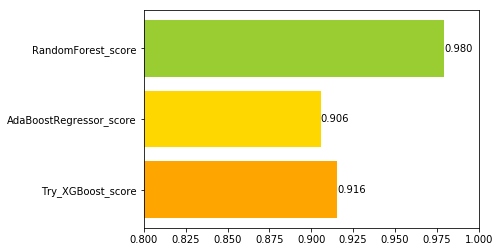

In [15]:
import matplotlib.pyplot as plt
score = [XGB_score,Ada_score,RF_score]
plt.barh(range(3),score,color=["orange","gold","yellowgreen"])
plt.yticks(range(3),["Try_XGBoost_score","AdaBoostRegressor_score","RandomForest_score"])
plt.xlim([0.8,1])
for loc1,loc2 in enumerate(score):
    plt.text(loc2,loc1,"{:.3f}".format(loc2),va='center')
plt.show()

In [14]:
XGB.draw_one_tree(0)

随机森林真的是，一骑绝尘的优秀  
我自己写的XGBoost除了慢以外，计算准确度还是可以和其他集成算法比拼一下的。    
XGBoost的优点是性能快呀，有机会再看看论文，学习下如何加快算法的计算速度。  
可能我调的参数不太理想，还是很过拟合。
比如这棵树，就甚是枝繁叶茂。